# Проект: Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. 

**Цель проекта: построить модель, которая предскажет конечную температуру стали.**

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Использовались данные, полученные из разных источников:

- данные об электродах;
- данные о подаче сыпучих материалов (объём);
- данные о подаче сыпучих материалов (время);
- данные о продувке сплава газом;
- результаты измерения температуры;
- данные о проволочных материалах (объём);
- данные о проволочных материалах (время).

Во всех выше указанных наборах данных столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## 1 Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
import lightgbm
import warnings
import catboost
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from catboost import Pool

In [2]:
    try:
        data_arc = pd.read_csv('/datasets/data_arc_new.csv')
        data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
        data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
        data_gas = pd.read_csv('/datasets/data_gas_new.csv')
        data_temp = pd.read_csv('/datasets/data_temp_new.csv')
        data_wire = pd.read_csv('/datasets/data_wire_new.csv')
        data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
        
    except:
        data_arc = pd.read_csv(r'C:\Users\valer\OneDrive\Документы\data_arc_new.csv')
        data_bulk = pd.read_csv(r'C:\Users\valer\OneDrive\Документы\data_bulk_new.csv')
        data_bulk_time = pd.read_csv(r'C:\Users\valer\OneDrive\Документы\data_bulk_time_new.csv')
        data_gas = pd.read_csv(r'C:\Users\valer\OneDrive\Документы\data_gas_new.csv')
        data_temp = pd.read_csv(r'C:\Users\valer\OneDrive\Документы\data_temp_new.csv')
        data_wire = pd.read_csv(r'C:\Users\valer\OneDrive\Документы\data_wire_new.csv')
        data_wire_time = pd.read_csv(r'C:\Users\valer\OneDrive\Документы\data_wire_time_new.csv')

Исследуем датасет data_arc (данные об электродах):

In [3]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [5]:
data_arc.describe(include='all')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14876,14876,NaN,NaN
top,NaN,2019-05-03 11:02:14,2019-05-03 11:06:02,NaN,NaN
freq,NaN,1,1,NaN,NaN
mean,1615.220422,NaN,NaN,0.662752,0.438986
std,934.571502,NaN,NaN,0.258885,5.873485
min,1.000000,NaN,NaN,0.223120,-715.479924
25%,806.000000,NaN,NaN,0.467115,0.337175
50%,1617.000000,NaN,NaN,0.599587,0.441639
75%,2429.000000,NaN,NaN,0.830070,0.608201


In [6]:
data_arc.corr()

,key,Активная мощность,Реактивная мощность
key,1.000000,-0.010220,-0.004834
Активная мощность,-0.010220,1.000000,0.031164
Реактивная мощность,-0.004834,0.031164,1.000000


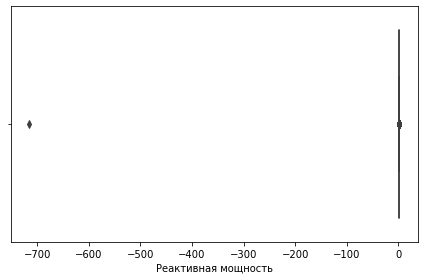

In [7]:
sns.boxplot(data_arc['Реактивная мощность'])
plt.tight_layout()

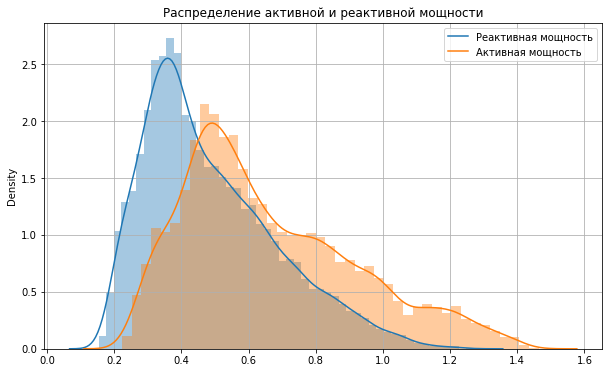

In [8]:
data = data_arc['Реактивная мощность'][data_arc['Реактивная мощность'] > 0] #посмотрим на распределение признака без выброса
ax = sns.distplot(data)
ax = sns.distplot(data_arc['Активная мощность'])

ax.set(title='Распределение активной и реактивной мощности', xlabel=None)
ax.grid(True)
ax.figure.set_size_inches(10, 6)
plt.legend(['Реактивная мощность', 'Активная мощность'])
plt.show()

Вывод по датасету data_arc: данные полные, однако в данных одно значение показателя реактивной мощности является отрицательным -715,5 (скорее всего это выброс). Графически распределения активной и реактивной мощностей выглядят одинаковыми (смещены только центры относительно друг друга).

Исследуем датасет data_bulk (данные об объеме подачи сыпучих материалов):

In [9]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


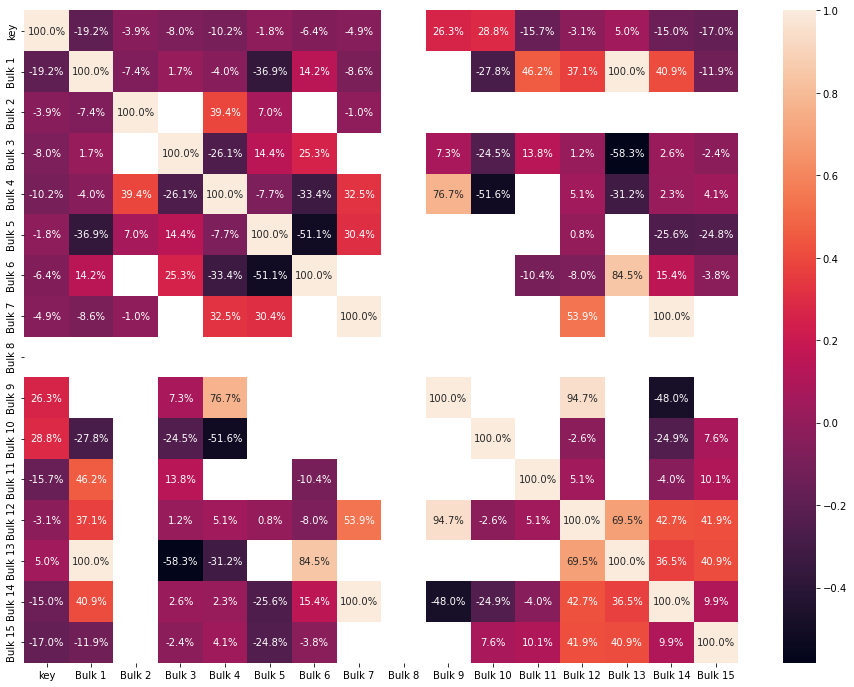

In [11]:
plt.figure(figsize=(16,12))
sns.heatmap(data_bulk.corr(), annot=True, fmt=".1%")
plt.show()

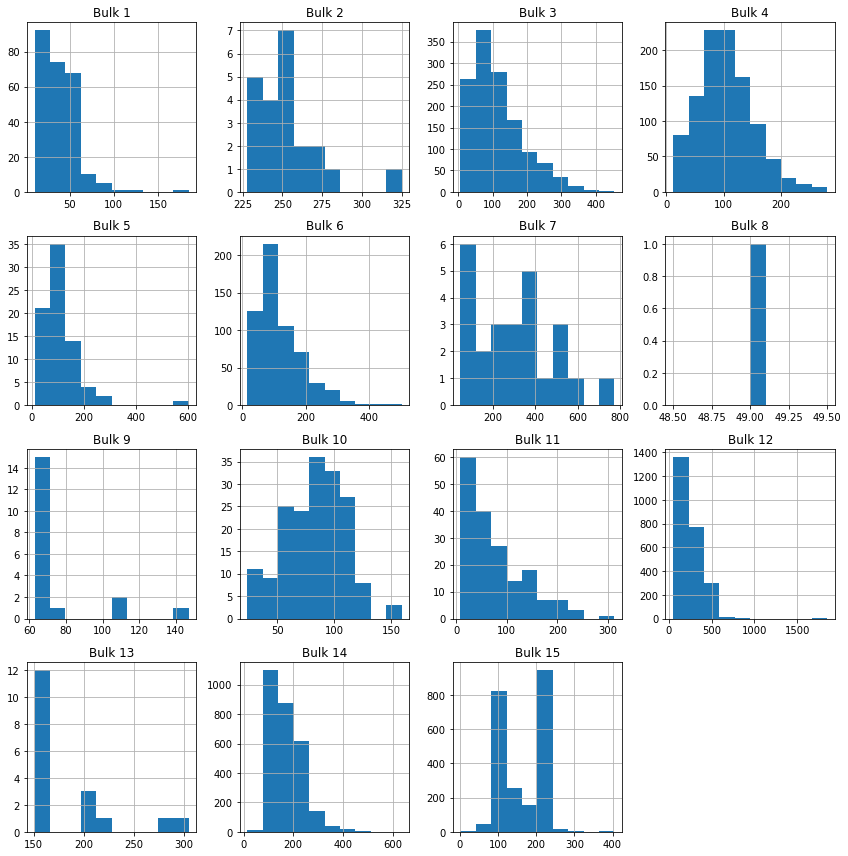

In [12]:
data_bulk_1 = data_bulk.drop('key', axis = 1)
data_bulk_1.hist(figsize = (12, 12))
plt.tight_layout()

In [13]:
data_bulk.isnull().sum() / len(data_bulk) * 100

key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64

Вывод по датасету data_bulk: высокая доля пропущенных значений объема подачи разного типа сыпучих материалов. Значения объемов разных типов материалов относительно часто коррелируют между собой (возможно их стоит удалить или объединить в однин признак).

Исследуем датасет data_bulk_time (данные о времени подачи сыпучих материалов):

In [14]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [15]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [16]:
data_bulk_time.isnull().sum() / len(data_bulk_time) * 100

key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64

Вывод по датасету data_bulk_time: высокая доля пропущенных значений времени подачи разного типа сыпучих материалов.

Исследуем датасет data_gas (данные о продувке сплава газом):

In [17]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [18]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [19]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


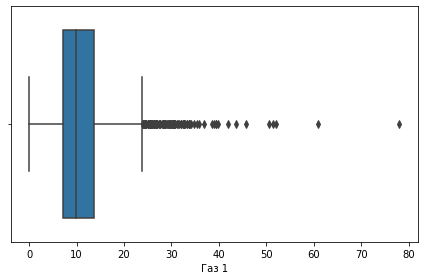

In [20]:
sns.boxplot(data_gas['Газ 1'])
plt.tight_layout()

Вывод по датасету data_gas: пропущенных данных в датасете нет. Однако существенные выбросы в значениях, которые можно удалить.

Исследуем датасет data_temp (результаты измерения температуры):

In [21]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [22]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [23]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


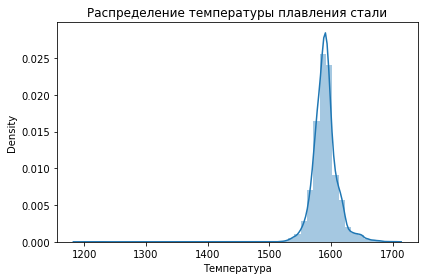

In [24]:
ax = sns.distplot(data_temp['Температура'])
plt.title('Распределение температуры плавления стали')
plt.tight_layout()

In [25]:
data_temp.isnull().sum() / len(data_temp) * 100

key              0.000000
Время замера     0.000000
Температура     18.942074
dtype: float64

Вывод по датасету data_temp: пропущено 18,9% значений температуры, разброс значений в данных небольшой.

Исследуем датасет data_wire (данные об объемах проволочных материалов):

In [26]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [27]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


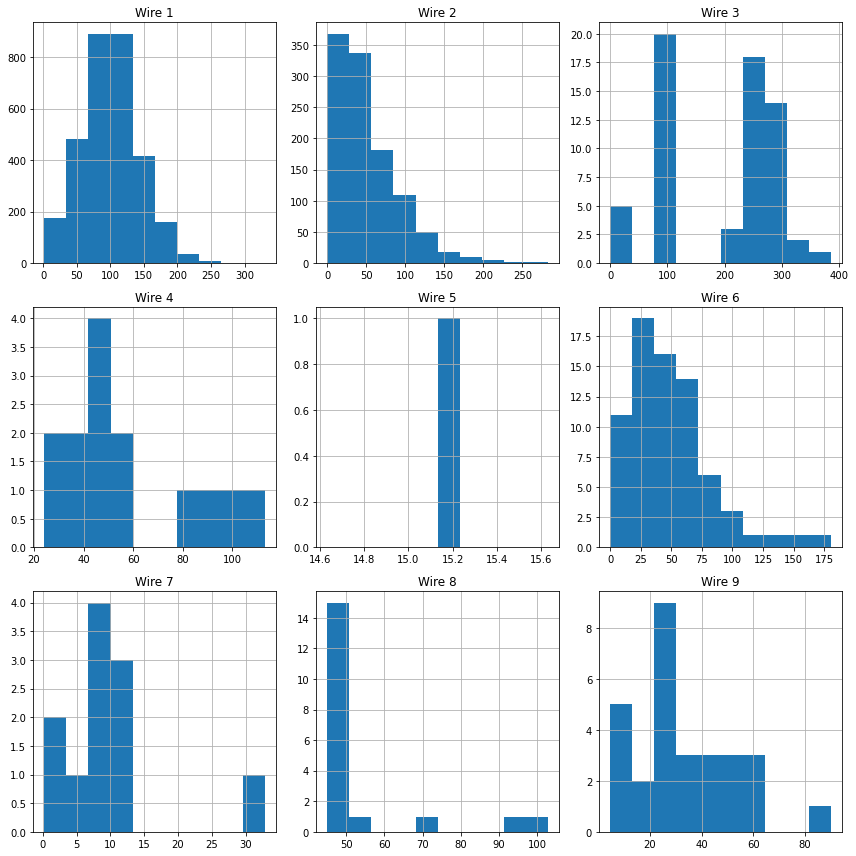

In [28]:
data_wire_k = data_wire.drop('key', axis = 1)
data_wire_k.hist(figsize = (12, 12))
plt.tight_layout()

In [29]:
data_wire.isnull().sum() / len(data_wire) * 100

key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64

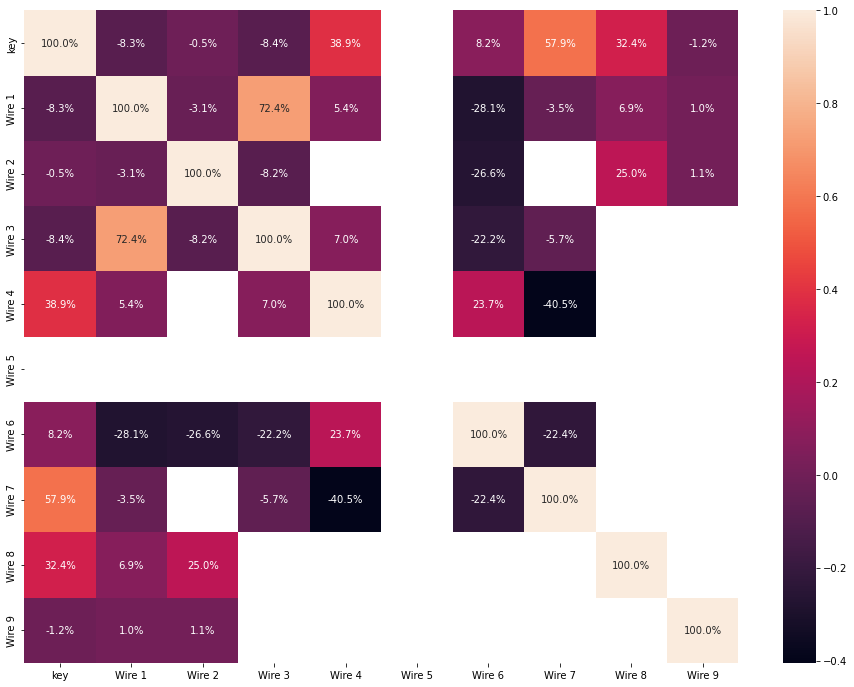

In [30]:
plt.figure(figsize=(16,12))
sns.heatmap(data_wire.corr(), annot=True, fmt=".1%")
plt.show()

Вывод по датасету data_wire: крайне высокая доля пропущенных значений по объемам разного типа проволочных материалов. В результате можно оставить только один тип материала или объединить их в один признак. Все датасеты нуждаются в объединении и предобработке.

Исследуем датасет data_wire_time (данные о времени использования проволочных материалов):

In [31]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [32]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
data_wire_time.isnull().sum() / len(data_wire_time) * 100

key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64

Вывод по датасету data_wire_time: такая же крайне высокая доля пропущенных значений по объемам разного типа проволочных материалов. В результате можно оставить время только с одним типом материала или объединить их в один признак.

**ВЫВОД ПО РАЗДЕЛУ 1:** 

Предоставленных данных достаточно для последующей предобработки и возможно для построения модели. В данных часть признаков сильно коррелирует между собой, существенная часть данных по используемых присадках отсутствует (возможно их стоит удалить или объединить в один признак), также одно значение показателя реактивной мощности является отрицательным -715,5 (скорее всего это выброс), присутствуют существенные выбросы в значениях объема газа, которые можно удалить.

Графически распределения активной и реактивной мощностей выглядят одинаковыми.

В датасете с целевым признаком пропущено 18,9% значений температуры (скорее всего можно удалить пропущенные значения после объединения), разброс значений в данных небольшой.

Все датасеты нуждаются в объединении и предобработке.

## 2 Предобработка данных

В датасете data_arc (информация об электродах) удалим выброс

In [34]:
react_min = data_arc['Реактивная мощность'].min()
index_names = data_arc[data_arc['Реактивная мощность'] == react_min].index

data_arc.drop(index_names, axis=0, inplace = True)

Рассчитаем время нагрева дуги:

In [35]:
data_arc['Время нагрева дуги'] = pd.to_datetime(data_arc['Конец нагрева дугой']) - pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Время нагрева дуги'] = data_arc['Время нагрева дуги'].map(lambda td:td.total_seconds())

Рассчитаем полную мощность из активной и реактивной мощности:

In [36]:
data_arc['Полная мощность'] = pow(data_arc['Реактивная мощность'] ** 2 + data_arc['Активная мощность'] ** 2, 1/2)
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дуги,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934


Удалим столбцы из датасета data_arc, которые не будем использовать в дальнейшем

In [37]:
data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1, inplace = True)
data_arc.head()

,key,Активная мощность,Реактивная мощность,Время нагрева дуги,Полная мощность
0,1,0.305130,0.211253,228.0,0.371123
1,1,0.765658,0.477438,185.0,0.902319
2,1,0.580313,0.430460,172.0,0.722536
3,1,0.518496,0.379979,365.0,0.642824
4,1,0.867133,0.643691,148.0,1.079934


Сгруппируем данные и расчитаем средние значения по колонкам датасета data_arc

In [38]:
data_arc_1 = data_arc.groupby(['key']).mean()
data_arc_1.columns = ['mean_active_power', 'mean_reactive_power', 'mean_time_heating', 'mean_full_power']
data_arc_1.head()

,mean_active_power,mean_reactive_power,mean_time_heating,mean_full_power
key,,,,
1,0.607346,0.428564,219.60,0.743747
2,0.534852,0.363339,202.75,0.647087
3,0.812728,0.587491,131.00,1.003845
4,0.676622,0.514248,185.25,0.850010
5,0.563238,0.421998,217.25,0.704245


Исходя из выводов, сделанных на этапе EDA, просуммируем все типы сыпучих материалов, которые практически не использовались за исключением Bulk 14 и Bulk 15, а затем удалим их

In [40]:
col_list= list(data_bulk)
col_list.remove('key')
col_list.remove('Bulk 14')
col_list.remove('Bulk 15')

data_bulk['Bulks_others'] = data_bulk[col_list].sum(axis=1)
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulks_others
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,249.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,279.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,239.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,288.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,281.0


In [41]:
data_bulk.drop(data_bulk.iloc[:, 1:14], axis = 1, inplace = True)
data_bulk.head()

,key,Bulk 14,Bulk 15,Bulks_others
0,1,150.0,154.0,249.0
1,2,149.0,154.0,279.0
2,3,152.0,153.0,239.0
3,4,153.0,154.0,288.0
4,5,151.0,152.0,281.0


Исходя из выводов, сделанных на этапе EDA, просуммируем все типы проволок, которые практически не использовались за исключением Wire 1, а затем удалим их

In [42]:
col_list = list(data_wire)
col_list.remove('key')
col_list.remove('Wire 1')

data_wire['Wires_others'] = data_wire[col_list].sum(axis=1)
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wires_others
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.11456


In [43]:
data_wire.drop(data_wire.iloc[:, 2:10], axis = 1, inplace = True)
data_wire.head()

,key,Wire 1,Wires_others
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


Из датасета data_gas удалим выбросы

In [44]:
data_gas.rename(columns = {'Газ 1': 'gas_volume'}, inplace=True)

In [45]:
gas_min = data_gas['gas_volume'].min()

In [46]:
data_gas = data_gas.loc[data_gas['gas_volume'] < 40]
data_gas = data_gas.loc[data_gas['gas_volume'] != gas_min]
data_gas.reset_index(drop=True)
data_gas.shape

(3230, 2)

Из датасета data_temp, где находится данные по целевому признаку удалим все пропущенные значения, удалим также единичные случае измерения температуры (когда цикл не был пройден), оставим только значения первоначальной температуры и конечной в рамках одного цикла

In [47]:
data_temp.dropna(axis=0, inplace=True)

In [48]:
index_names = data_temp[data_temp['Температура'] < 1400].index
data_temp.drop(index_names, inplace=True)
data_temp.shape

(14660, 3)

In [49]:
data_temp_group = data_temp.groupby(by='key').count()
data_temp_group['key'] = data_temp_group.index
data_temp_one = data_temp_group.query('Температура == 1')
list_to_del = data_temp_one['key'].tolist()
print('Количество единичных случаев измерения температуры', len(list_to_del))

Количество единичных случаев измерения температуры 740


In [50]:
data_temp.drop(data_temp[data_temp['key'].isin(list_to_del)].index, inplace=True)
data_temp.shape

(13920, 3)

Рассчитаем количество раз, когда температура измерялась (для использования в качестве одного из возможных признаков)

In [51]:
data_temp_numb = data_temp.groupby(by = 'key', as_index = False).count()[['key','Температура']]
data_temp_numb.columns = ['key', 'number_of_measurements']

In [52]:
temp_first = data_temp.groupby('key').first().reset_index()
temp_last = data_temp.groupby('key').last().reset_index()

In [53]:
data_temp_new = temp_first.merge(temp_last, on='key', how='inner')

In [54]:
display(data_temp_new)

,key,Время замера_x,Температура_x,Время замера_y,Температура_y
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...
2470,2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0
2471,2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0
2472,2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0
2473,2498,2019-08-10 12:58:11,1591.0,2019-08-10 13:23:31,1594.0


Рассчитаем длительность измерения температуры (для использования в качестве одного из возможных признаков)

In [55]:
data_temp_new['duration_temp_measurement'] = pd.to_datetime(data_temp_new['Время замера_y']) - pd.to_datetime(data_temp_new['Время замера_x'])
data_temp_new['duration_temp_measurement'] = data_temp_new['duration_temp_measurement'].map(lambda td:td.total_seconds())

In [56]:
list_del = data_temp_new.columns 
data_temp_new.drop([list_del[1], list_del[3]], axis = 1, inplace=True)
data_temp_new.rename(columns = {'Температура_x': 'first_temp_measurement', 'Температура_y': 'last_temp_measurement'}, inplace=True)
display(data_temp_new)

,key,first_temp_measurement,last_temp_measurement,duration_temp_measurement
0,1,1571.0,1613.0,1714.0
1,2,1581.0,1602.0,1265.0
2,3,1596.0,1599.0,1753.0
3,4,1601.0,1625.0,1220.0
4,5,1576.0,1602.0,1536.0
...,...,...,...,...
2470,2495,1570.0,1591.0,1380.0
2471,2496,1554.0,1591.0,1705.0
2472,2497,1571.0,1589.0,962.0
2473,2498,1591.0,1594.0,1520.0


Соединим все таблицы по ключу key (номер ковша)

In [57]:
data_1 = data_temp_new.merge(data_temp_numb, on='key', how='inner')
data_2 = data_1.merge(data_arc_1, on='key', how='inner')
data_3 = data_2.merge(data_bulk, on='key', how='inner')
data_4 = data_3.merge(data_wire, on='key', how='inner')
data_5 = data_4.merge(data_gas, on='key', how='inner')
display(data_5)

,key,first_temp_measurement,last_temp_measurement,duration_temp_measurement,number_of_measurements,mean_active_power,mean_reactive_power,mean_time_heating,mean_full_power,Bulk 14,Bulk 15,Bulks_others,Wire 1,Wires_others,gas_volume
0,1,1571.0,1613.0,1714.0,6,0.607346,0.428564,219.600000,0.743747,150.0,154.0,249.0,60.059998,0.00000,29.749986
1,2,1581.0,1602.0,1265.0,5,0.534852,0.363339,202.750000,0.647087,149.0,154.0,279.0,96.052315,0.00000,12.555561
2,3,1596.0,1599.0,1753.0,6,0.812728,0.587491,131.000000,1.003845,152.0,153.0,239.0,91.160157,0.00000,28.554793
3,4,1601.0,1625.0,1220.0,5,0.676622,0.514248,185.250000,0.850010,153.0,154.0,288.0,89.063515,0.00000,18.841219
4,5,1576.0,1602.0,1536.0,5,0.563238,0.421998,217.250000,0.704245,151.0,152.0,281.0,89.238236,9.11456,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,2495,1570.0,1591.0,1380.0,5,0.792033,0.552734,180.750000,0.967180,129.0,223.0,367.0,89.150879,0.00000,7.125735
2317,2496,1554.0,1591.0,1705.0,7,0.695820,0.478672,156.666667,0.845053,129.0,226.0,441.0,114.179527,0.00000,9.412616
2318,2497,1571.0,1589.0,962.0,4,1.201746,0.817364,189.666667,1.453639,124.0,226.0,315.0,94.086723,9.04800,6.271699
2319,2498,1591.0,1594.0,1520.0,6,0.640462,0.447964,150.000000,0.781983,129.0,207.0,397.0,118.110717,0.00000,14.953657


Проведем корреляционный анализ полученных признаков

In [58]:
data_5.corr().round(2)

,key,first_temp_measurement,last_temp_measurement,duration_temp_measurement,number_of_measurements,mean_active_power,mean_reactive_power,mean_time_heating,mean_full_power,Bulk 14,Bulk 15,Bulks_others,Wire 1,Wires_others,gas_volume
key,1.00,-0.02,-0.09,-0.03,-0.03,0.01,0.01,0.01,0.01,-0.15,-0.12,0.03,-0.02,0.02,-0.04
first_temp_measurement,-0.02,1.00,0.31,0.20,-0.19,-0.01,-0.00,-0.44,-0.01,-0.15,-0.06,-0.08,0.29,-0.07,0.03
last_temp_measurement,-0.09,0.31,1.00,0.13,0.19,0.04,0.03,0.20,0.04,0.06,0.17,0.18,0.31,-0.20,0.07
duration_temp_measurement,-0.03,0.20,0.13,1.00,0.58,0.03,0.03,0.06,0.03,0.25,0.08,0.31,0.20,0.10,0.42
number_of_measurements,-0.03,-0.19,0.19,0.58,1.00,0.04,0.04,-0.00,0.04,0.29,0.04,0.38,0.15,0.09,0.38
mean_active_power,0.01,-0.01,0.04,0.03,0.04,1.00,0.97,0.04,1.00,0.01,0.02,0.06,0.03,0.01,0.06
mean_reactive_power,0.01,-0.00,0.03,0.03,0.04,0.97,1.00,0.02,0.99,0.01,0.01,0.06,0.04,0.01,0.06
mean_time_heating,0.01,-0.44,0.20,0.06,-0.00,0.04,0.02,1.00,0.03,0.24,0.25,0.30,-0.12,-0.02,0.10
mean_full_power,0.01,-0.01,0.04,0.03,0.04,1.00,0.99,0.03,1.00,0.01,0.01,0.06,0.04,0.01,0.06
Bulk 14,-0.15,-0.15,0.06,0.25,0.29,0.01,0.01,0.24,0.01,1.00,0.11,0.26,-0.05,0.09,0.28


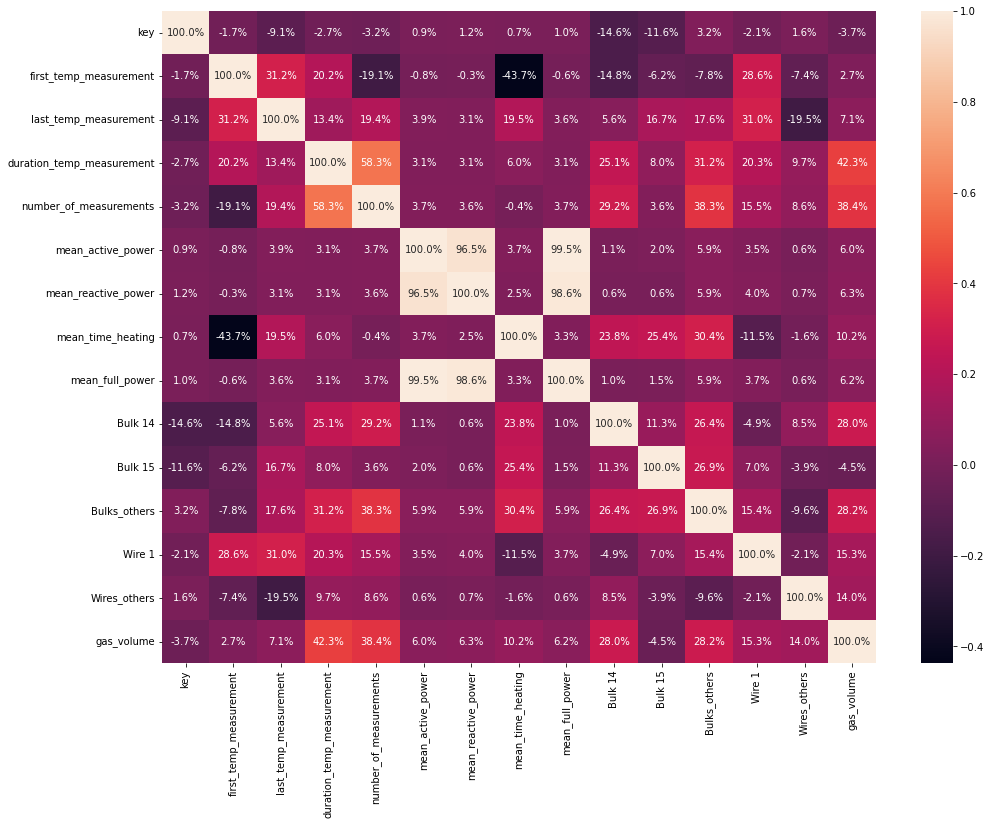

In [59]:
plt.figure(figsize=(16,12))
sns.heatmap(data_5.corr(), annot=True, fmt=".1%")
plt.show()

Удалим признаки, которые коррелируют между собой, а также номер ковша

In [60]:
columns_to_drop = ['key',
                'mean_active_power', 
                'mean_reactive_power']

In [61]:
data_5.drop(labels=columns_to_drop, axis = 1, inplace=True)
data_all = data_5
data_all.shape

(2321, 12)

Разделим признаки на целевой и нецелевые

In [62]:
target = data_all['last_temp_measurement']
features = data_all.drop('last_temp_measurement', axis = 1)

Разделим полученный датасет на обучающую и тестовую выборки

In [63]:
RANDOM_STATE = 240423

In [64]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.75, random_state = RANDOM_STATE)

Заполним пропуски в обучающей выборке 

In [65]:
features_train = features_train.fillna(0)

Стандартизируем данные (для нецелевых признаков) в обучающей и тестовой выборках

In [66]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

**ВЫВОД ПО РАЗДЕЛУ 2:**

В результате проведения предобработки данных:

1) Удалили выбросы из изначальных датасетов;

2) Сгруппировали данные по номеру ковша;

3) Построили новые признаки, часть из которых будет использоваться при построении моделей;

4) Объединили датасеты в один общий;

5) Провели корреляционный анализ и удалили признаки, которые коррелируют между собой;

6) Выделили целевой и нецелевые признаки и разделили полученный общий датасет на обучающую и тестовую выборки (0.25 - тестовая);

7) Заполнили пропуски в обучающей выборке;

8) Стандартизировали нецелевые признаки.

## Обучение моделей

Проведем поиск оптимальных параметров модели RandomForestRegressor с помощью кроссвалидации на обучающей выборке

In [67]:
start_rf = time.time()

model_rf = RandomForestRegressor()
parameters_rf = {'criterion':['mse'],
                'n_estimators':[x for x in range(30, 731, 50)],
                'random_state': [RANDOM_STATE]}

grid_rf = RandomizedSearchCV(model_rf, parameters_rf, scoring = 'neg_mean_absolute_error',  cv = 5, n_jobs=-1)
model_rf = grid_rf.fit(features_train_scaled, target_train)
print('Наименьшее значение MAE в модели RandomForestRegressor равно {} \n при следующих гиперпараметрах: {}'
      .format(-grid_rf.best_score_, grid_rf.best_params_))

end_rf = time.time() - start_rf
print('Время обучения на кроссвалидации', round(end_rf), 'секунд')

Наименьшее значение MAE в модели RandomForestRegressor равно 6.485725082664148 
 при следующих гиперпараметрах: {'random_state': 240423, 'n_estimators': 730, 'criterion': 'mse'}
Время обучения на кроссвалидации 20 секунд


Проведем поиск оптимальных параметров модели LGBMRegressor с помощью кроссвалидации на обучающей выборке

In [68]:
start_lgbm = time.time()

model_lgbm = LGBMRegressor()
parameters_lgbm = {'learning_rate': [x/100 for x in range(1, 11)],
                'max_depth': [x for x in range(4, 21, 2)],
                'n_estimators': [x for x in range(30, 731, 50)],
                'random_state': [RANDOM_STATE]}

grid_lgbm = RandomizedSearchCV(model_lgbm, parameters_lgbm, scoring = 'neg_mean_absolute_error',  cv = 5, n_jobs=-1)
model_lgbm = grid_lgbm.fit(features_train_scaled, target_train)
print('Наименьшее значение MAE в модели LGBMRegressor равно {} \n при следующих гиперпараметрах: {}'
      .format(-grid_lgbm.best_score_, grid_lgbm.best_params_))

end_lgbm = time.time() - start_lgbm
print('Время обучения на кроссвалидации', round(end_lgbm), 'секунд')

Наименьшее значение MAE в модели LGBMRegressor равно 6.18998986059388 
 при следующих гиперпараметрах: {'random_state': 240423, 'n_estimators': 230, 'max_depth': 4, 'learning_rate': 0.06}
Время обучения на кроссвалидации 5 секунд


Проведем поиск оптимальных параметров модели CatBoostRegressor с помощью кроссвалидации на обучающей выборке

In [69]:
start_cat = time.time()

model_cb = CatBoostRegressor()

parameters_cb = {'learning_rate': [x/100 for x in range(1, 11)],
                'depth': [x for x in range(4, 13, 2)],
                'iterations': [30, 50, 100],
                'random_state': [RANDOM_STATE]}

grid_cb = RandomizedSearchCV(model_cb, parameters_cb, scoring = 'neg_mean_absolute_error',  cv = 5, n_jobs=-1)
model_cb = grid_cb.fit(features_train_scaled, target_train)
print('Наименьшее значение MAE в модели CatBoostRegressor равно {} \n при следующих гиперпараметрах: {}'
      .format(-grid_cb.best_score_, grid_cb.best_params_))

end_cat = time.time() - start_cat
print('Время обучения на кроссвалидации', round(end_cat), 'секунд')

0:	learn: 10.6259425	total: 180ms	remaining: 17.8s
1:	learn: 10.3968379	total: 217ms	remaining: 10.6s
2:	learn: 10.1743946	total: 254ms	remaining: 8.21s
3:	learn: 9.9832449	total: 280ms	remaining: 6.72s
4:	learn: 9.8142293	total: 306ms	remaining: 5.81s
5:	learn: 9.6520708	total: 330ms	remaining: 5.16s
6:	learn: 9.5079927	total: 351ms	remaining: 4.66s
7:	learn: 9.3507879	total: 365ms	remaining: 4.19s
8:	learn: 9.2301421	total: 372ms	remaining: 3.76s
9:	learn: 9.1163874	total: 380ms	remaining: 3.42s
10:	learn: 9.0155231	total: 386ms	remaining: 3.12s
11:	learn: 8.9034770	total: 394ms	remaining: 2.88s
12:	learn: 8.8086193	total: 400ms	remaining: 2.67s
13:	learn: 8.6928437	total: 406ms	remaining: 2.5s
14:	learn: 8.5772525	total: 415ms	remaining: 2.35s
15:	learn: 8.5090800	total: 422ms	remaining: 2.22s
16:	learn: 8.4307932	total: 431ms	remaining: 2.1s
17:	learn: 8.3492306	total: 438ms	remaining: 2s
18:	learn: 8.2861442	total: 447ms	remaining: 1.91s
19:	learn: 8.1996320	total: 455ms	remaining

In [70]:
index = ['CatBoostRegressor',
         'LGBMRegressor',
         'RandomForestRegressor']
final = {'MAE на кросс-валидации, градусов':[round(-grid_cb.best_score_, 1),
                                 round(-grid_lgbm.best_score_, 1),
                                 round(-grid_rf.best_score_, 1)],
        'Время на кросс-валидацию, сек':[round(end_cat),
                                         round(end_lgbm),
                                         round(end_rf)]}

data_final = pd.DataFrame(data=final, index=index)
display(data_final)

,"MAE на кросс-валидации, градусов","Время на кросс-валидацию, сек"
CatBoostRegressor,6.3,21
LGBMRegressor,6.2,5
RandomForestRegressor,6.5,20


Все три модели на кроссвалидации показали значение метрики MAE соответствующие заданной (MAE < 6.8)

Обучим все три модели со значениями найденных гиперпараметров

In [72]:
start_cat_1 = time.time()

model_cat_final = CatBoostRegressor(depth=8, iterations=100, learning_rate=0.09, random_state=RANDOM_STATE)
model_cat_final.fit(features_train_scaled, target_train)

end_cat_1 = time.time() - start_cat_1
print('Время обучения модели CatBoostRegressor', round(end_cat_1), 'секунд')

0:	learn: 10.6259425	total: 12.9ms	remaining: 1.28s
1:	learn: 10.3968379	total: 20.8ms	remaining: 1.02s
2:	learn: 10.1743946	total: 43.3ms	remaining: 1.4s
3:	learn: 9.9832449	total: 69ms	remaining: 1.66s
4:	learn: 9.8142293	total: 87.2ms	remaining: 1.66s
5:	learn: 9.6520708	total: 98.7ms	remaining: 1.55s
6:	learn: 9.5079927	total: 115ms	remaining: 1.53s
7:	learn: 9.3507879	total: 133ms	remaining: 1.53s
8:	learn: 9.2301421	total: 147ms	remaining: 1.49s
9:	learn: 9.1163874	total: 165ms	remaining: 1.48s
10:	learn: 9.0155231	total: 177ms	remaining: 1.43s
11:	learn: 8.9034770	total: 188ms	remaining: 1.38s
12:	learn: 8.8086193	total: 197ms	remaining: 1.32s
13:	learn: 8.6928437	total: 207ms	remaining: 1.27s
14:	learn: 8.5772525	total: 218ms	remaining: 1.23s
15:	learn: 8.5090800	total: 225ms	remaining: 1.18s
16:	learn: 8.4307932	total: 234ms	remaining: 1.14s
17:	learn: 8.3492306	total: 240ms	remaining: 1.09s
18:	learn: 8.2861442	total: 250ms	remaining: 1.06s
19:	learn: 8.1996320	total: 257ms	r

In [73]:
start_lgbm_1 = time.time()

model_lgbm = LGBMRegressor(max_depth=6, n_estimators=230, learning_rate=0.04, random_state=RANDOM_STATE)
model_lgbm.fit(features_train_scaled, target_train)

end_lgbm_1 = time.time() - start_lgbm_1
print('Время обучения модели LGBMRegressor', round(end_lgbm_1), 'секунд')

Время обучения модели LGBMRegressor 0 секунд


In [74]:
start_rf_1 = time.time()

model_rf = RandomForestRegressor(criterion='mse', n_estimators=730, random_state=RANDOM_STATE)
model_rf.fit(features_train_scaled, target_train)

end_rf_1 = time.time() - start_rf_1
print('Время обучения модели RandomForestRegressor', round(end_rf_1), 'секунд')

Время обучения модели RandomForestRegressor 6 секунд


In [75]:
data_final['Время обучения модели'] = [round(end_cat_1), round(end_lgbm_1), round(end_rf_1)]
data_final['Общее время обучения модели, сек'] = data_final['Время на кросс-валидацию, сек'] + data_final['Время обучения модели']
display(data_final)

,"MAE на кросс-валидации, градусов","Время на кросс-валидацию, сек",Время обучения модели,"Общее время обучения модели, сек"
CatBoostRegressor,6.3,21,1,22
LGBMRegressor,6.2,5,0,5
RandomForestRegressor,6.5,20,6,26


**ВЫВОД ПО РАЗДЕЛУ 3:**

Все три используемые модели показывают метрику лучше необходимой (МАЕ < 6.8), однако LGBMRegressor стабильно показывает лучший результат (метрика МАЕ = 6.2) за более короткое время (от 2-х до 5 секунд). Выберем именно эту модель в качестве финальной.

## Тестирование финальной модели

Найдем значение метрики MAE на тестовой выборке в финальной модели (LGBMRegressor)

In [76]:
lgbm_predicted_final = model_lgbm.predict(features_test_scaled)
MAE_lgbm_test_predicted = mean_absolute_error(target_test, lgbm_predicted_final)
print('MAE модели LGBMRegressor на тестовой выборке', round(MAE_lgbm_test_predicted, 1))

MAE модели LGBMRegressor на тестовой выборке 6.3


**ВЫВОД ПО РАЗДЕЛУ 4:**

Полученный результат на тесте (метрика МАЕ = 6.3) финальной модели LGBMRegressor является полностью удовлетворяющим заданному изначально (MAE < 6.8).

## Анализ факторов

Проведем анализ важности признаков, участвовавших в модели LGBMRegressor, как финальной модели

In [77]:
feat_imp = pd.DataFrame({'Value': model_lgbm.feature_importances_,'Feature':features.columns.tolist()}).sort_values(by="Value",ascending=False)

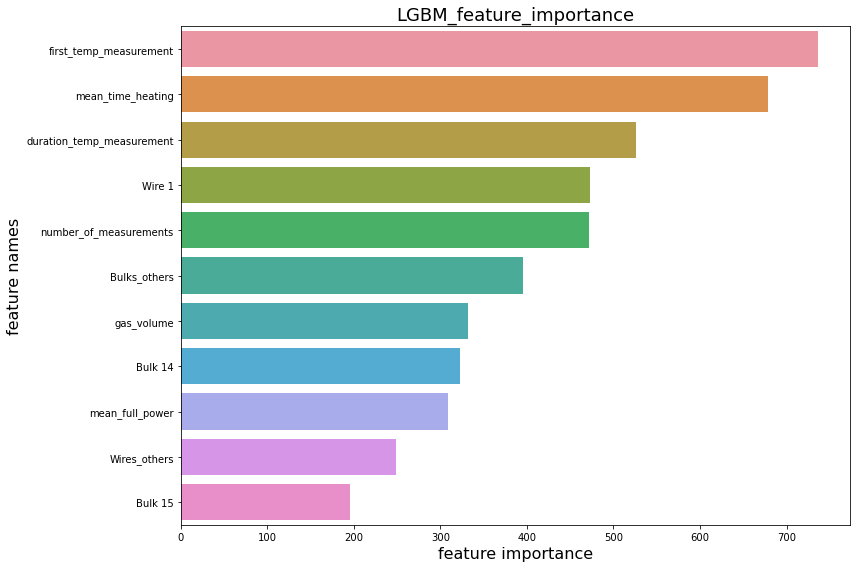

In [78]:
plt.figure(figsize=(12,8))

sns.barplot(y=feat_imp['Feature'], x=feat_imp['Value'])
plt.title('LGBM_feature_importance', fontsize=18)
plt.xlabel('feature importance', fontsize=16)
plt.ylabel('feature names', fontsize=16)
plt.tight_layout()

**ВЫВОД ПО РАЗДЕЛУ 4:**

Наибольшее влияние в финальной модели LGBMRegressor оказали признаки:


1) Среднее время нагревания дугой ковша;

2) Значение температуры, измеренное в начале цикла;

3) Длительность измерения температуры;

4) Проволка первого типа, используемая для легирования стали;

5) Количество измерений температуры.

## Отчет по проекту

В результате реализации проекта на этапе предобработки данных признаки с высокой долей пропущенных значений (сыпучие материалы и проволки разного типа, используемые при легировании стали) были объединены в отдельные признаки - прочие сыпучие материалы и прочие типы проволки, так как на этапе сбора информации выснилось, что пропуск значения означает только, что данный материалы в данном цикле не добавлялся, а сами эти признаки сильно коррелируют между собой. Таким образом, получились признаки с новыми значениями.<br>
Также на этапе сбора информации от заказчика стало ясно, что промежуточные значения измеренной температуры не интересны с точки зрения анализа и построения модели, интересны только первое значение измеренной температуры и последнее значение.<br>
 
На этапе построения модели возникли вопросы с тем, какие признаки стоит оставить в сформированном датасете, так как изначально при первом построении метрика MAE (средняя абсолютная ошибка) была более семи.<br>
В результате перебора признаков (с учетом корреляционного анализа) для построения моделей было выбрано 11 признаков при начальных данных порядка 28 признаков (первичные датасеты).

При реализации проекта можно выделить 4 основных шага:

1) Анализ первичных данных и сбор дополнительной информации от заказчика;<br>

2) Предобработка данных<br>
 - удалены выбросы из изначальных датасетов;<br>
 - сгруппированы данные по номеру ковша;<br>
 - построены новые признаки для использования при построении моделей;<br>
 - первичные датасеты объеденены в один общий;<br>
 - проведен корреляционный анализ и удалены признаки, которые сильно коррелируют между собой;<br>
 - выделены целевой и нецелевые признаки и разделены полученный общий датасет на обучающую и тестовую выборки;<br>
 - заполнены пропуски в обучающей выборке;<br>
 - стандартизированы нецелевые признаки.<br>
 
3) Выбор трех моделей для обучения (типа дерева решений (RandomForestregressor) и градиентного бустинга (LGBMRegressor и CatBoostRegressor)) и подбор гиперпараметров для решения задачи (минимизация средней абсолютной ошибки < 6.8 градусов);<br>

4) Выбор финальной модели и ее тестирование, а также анализ важности признаков, входящих в нее.

Итоговая модель: модель градиентного бустинга LGBMRegressor со следующими гиперпараметрами:<br> 
- максимальная глубина дерева (max_depth) = 6;<br> 
- число деревьев в лесу (n_estimators) = 230;<br> 
- скорость обучения (learning_rate) = 0.04;<br> 
- random_state=240423.<br> 

Качество итоговой модели на тестовой выборке МАЕ = 6.3 (при ориентировочной метрики МАЕ < 6.8)

Признаки, используемые для обучения итоговой модели:

1) Среднее время нагревания дугой ковша<br> 
   Время было получено из разности времени измерения нагрева в каждой итерации каждого цикла в секундах, полученные значения      просуммированы и разделены на количество итераций.
   
2) Значение температуры, измеренное в начале цикла<br>
   Признак был дан в первичном датасете. Значения ниже температуры плавления по тех.паспорту (менее 1450 градусов) были исключены. 
   
3) Длительность измерения температуры<br>
   Время (в секундах) было получено из разности времени последнего измерения температуры и первого измерения в рамках одного цикла.
   
4) Проволка первого типа для легирования стали<br>
   Признак был дан в первичном датасете. Предобрабоки не было, кроме заполнения пропущенных значений нулями в обучающей выборке.
   
5) Проволки иных типов для легирования стали<br>
   Признак был получен путем сумммирования всех типов проволки в каждой итерации каждого цикла за исключением проволки первого типа.
   
6) Количество измерений температуры<br>
   Признак был получен путем суммирования количества измерений температуры в рамках каждого цикла.

7) Средняя полная мощность<br>
   Признак был получен из активной и реактивной мощности по формуле расчета полной мощности. Предварительно выбросы в данных активной и реактивной мощности были удалены.
   
8) Сыпучий материал 14-го типа для легирования стали<br>
   Признак был дан в первичном датасете. Предобрабоки не было, кроме заполнения пропущенных значений нулями в обучающей выборке.
   
9) Сыпучий материал 15-го типа для легирования стали<br>
   Признак был дан в первичном датасете. Предобрабоки не было, кроме заполнения пропущенных значений нулями в обучающей выборке.
   
10) Сыпучие материалы иных типов для легирования стали<br>
    Признак был получен путем сумммирования всех типов сыпучих материалов в каждой итерации каждого цикла за исключением сыпучих материалов 14-го и 15-го типов.

11) Инертный газ для продува сплава<br>
    Признак был дан в первичном датасете. Выбросы в данных были удалены.
    
    
Для улучшения модели рекомендуется собрать дополнительные данные по производству (какой химический состав у легирующих материалов, какой состав газа, как организован процесс с точки зрения участия рабочих бригад и т.д.). После этого проверить новые собранные признаки на корреляцию с конечной температурой и применить их в текущей модели или другой модели. Также рекомендуется фиксировать каждый факт превышения оптимальной температуры плавления (чтобы выявить разброс), что также можно будет использовать для улучшения текущей модели или новой модели.